In [0]:
import numpy as np
import tensorflow as tf
from six.moves import urllib
from PIL import Image, ImageOps, ImageDraw

In [219]:
!wget https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names

--2019-03-23 15:56:38--  https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 625 [text/plain]
Saving to: ‘coco.names’

coco.names          100%[===================>]     625  --.-KB/s    in 0s      

2019-03-23 15:56:38 (116 MB/s) - ‘coco.names’ saved [625/625]



In [0]:
def draw_boxes(boxes, img, cls_names, detection_size, is_letter_box_image):
    img = Image.fromarray(img[0].astype('uint8'))
    draw = ImageDraw.Draw(img)

    for cls, bboxs in boxes.items():
        color = tuple(np.random.randint(0, 256, 3))
        for box, score in bboxs:
            box = convert_to_original_size(box, np.array(detection_size),
                                           np.array(img.size),
                                           is_letter_box_image)
            draw.rectangle(box, outline=color)
            draw.text(box[:2], '{} {:.2f}%'.format(cls_names[cls], score * 100), fill=color)
    return img

def convert_to_original_size(box, size, original_size, is_letter_box_image):
    if is_letter_box_image:
        box = box.reshape(2, 2)
        box[0, :] = letter_box_pos_to_original_pos(box[0, :], size, original_size)
        box[1, :] = letter_box_pos_to_original_pos(box[1, :], size, original_size)
    else:
        ratio = original_size / size
        box = box.reshape(2, 2) * ratio
    return list(box.reshape(-1))
  
def _iou(box1, box2):
    b1_x0, b1_y0, b1_x1, b1_y1 = box1
    b2_x0, b2_y0, b2_x1, b2_y1 = box2

    int_x0 = max(b1_x0, b2_x0)
    int_y0 = max(b1_y0, b2_y0)
    int_x1 = min(b1_x1, b2_x1)
    int_y1 = min(b1_y1, b2_y1)

    int_area = (int_x1 - int_x0) * (int_y1 - int_y0)

    b1_area = (b1_x1 - b1_x0) * (b1_y1 - b1_y0)
    b2_area = (b2_x1 - b2_x0) * (b2_y1 - b2_y0)

    # we add small epsilon of 1e-05 to avoid division by 0
    iou = int_area / (b1_area + b2_area - int_area + 1e-05)
    return iou


def non_max_suppression(predictions_with_boxes, confidence_threshold, iou_threshold=0.4):

    conf_mask = np.expand_dims((predictions_with_boxes[:, :, 4] > confidence_threshold), -1)
    predictions = predictions_with_boxes * conf_mask

    result = {}
    for i, image_pred in enumerate(predictions):
        shape = image_pred.shape
        non_zero_idxs = np.nonzero(image_pred)
        image_pred = image_pred[non_zero_idxs]
        image_pred = image_pred[0:85*int(np.floor(len(image_pred)/85))]
        image_pred = image_pred.reshape(-1, 85)

        bbox_attrs = image_pred[:, :5]
        classes = image_pred[:, 5:]
        classes = np.argmax(classes, axis=-1)

        unique_classes = list(set(classes.reshape(-1)))

        for cls in unique_classes:
            cls_mask = classes == cls
            cls_boxes = bbox_attrs[np.nonzero(cls_mask)]
            cls_boxes = cls_boxes[cls_boxes[:, -1].argsort()[::-1]]
            cls_scores = cls_boxes[:, -1]
            cls_boxes = cls_boxes[:, :-1]

            while len(cls_boxes) > 0:
                box = cls_boxes[0]
                score = cls_scores[0]
                if cls not in result:
                    result[cls] = []
                result[cls].append((box, score))
                cls_boxes = cls_boxes[1:]
                cls_scores = cls_scores[1:]
                ious = np.array([_iou(box, x) for x in cls_boxes])
                iou_mask = ious < iou_threshold
                cls_boxes = cls_boxes[np.nonzero(iou_mask)]
                cls_scores = cls_scores[np.nonzero(iou_mask)]

    return result


def load_coco_names(file_name):
    names = {}
    with open(file_name) as f:
        for id, name in enumerate(f):
            names[id] = name
    return names

def convert_to_original_size(box, size, original_size, is_letter_box_image):
    if is_letter_box_image:
        box = box.reshape(2, 2)
        box[0, :] = letter_box_pos_to_original_pos(box[0, :], size, original_size)
        box[1, :] = letter_box_pos_to_original_pos(box[1, :], size, original_size)
    else:
        ratio = original_size / size
        box = box.reshape(2, 2) * ratio
    return list(box.reshape(-1))

  
def letter_box_pos_to_original_pos(letter_pos, current_size, ori_image_size)-> np.ndarray:

    letter_pos = np.asarray(letter_pos, dtype=np.float)
    current_size = np.asarray(current_size, dtype=np.float)
    ori_image_size = np.asarray(ori_image_size, dtype=np.float)
    final_ratio = min(current_size[0]/ori_image_size[0], current_size[1]/ori_image_size[1])
    pad = 0.5 * (current_size - final_ratio * ori_image_size)
    pad = pad.astype(np.int32)
    to_return_pos = (letter_pos - pad) / final_ratio
    return to_return_pos
  
def letter_box_image(image: Image.Image, output_height: int, output_width: int, fill_value)-> np.ndarray:

    height_ratio = float(output_height)/image.size[1]
    width_ratio = float(output_width)/image.size[0]
    fit_ratio = min(width_ratio, height_ratio)
    fit_height = int(image.size[1] * fit_ratio)
    fit_width = int(image.size[0] * fit_ratio)
    fit_image = np.asarray(image.resize((fit_width, fit_height), resample=Image.BILINEAR))

    if isinstance(fill_value, int):
        fill_value = np.full(fit_image.shape[2], fill_value, fit_image.dtype)

    to_return = np.tile(fill_value, (output_height, output_width, 1))
    pad_top = int(0.5 * (output_height - fit_height))
    pad_left = int(0.5 * (output_width - fit_width))
    to_return[pad_top:pad_top+fit_height, pad_left:pad_left+fit_width] = fit_image
    return to_return

In [0]:
def get_boxes_and_inputs(model):

    boxes = detections_boxes(model)

    return boxes
  
def detections_boxes(detections):

    center_x, center_y, width, height, attrs = tf.split(
        detections, [1, 1, 1, 1, -1], axis=-1)
    w2 = width / 2
    h2 = height / 2
    x0 = center_x - w2
    y0 = center_y - h2
    x1 = center_x + w2
    y1 = center_y + h2

    boxes = tf.concat([x0, y0, x1, y1], axis=-1)
    detections = tf.concat([boxes, attrs], axis=-1, name="output_boxes")
    return detections

def _get_size(shape, data_format):
    if len(shape) == 4:
        shape = shape[1:]
    return shape[1:3] if data_format == 'NCHW' else shape[0:2]

def _detection_layer(inputs, num_classes, anchors, img_size, data_format):
    num_anchors = len(anchors)
    
    predictions = inputs
    
    shape = predictions.get_shape().as_list()
    
    grid_size = _get_size(shape, data_format)
    dim = grid_size[0] * grid_size[1]
    bbox_attrs = 5 + num_classes

    if data_format == 'NCHW':
        predictions = tf.reshape(
            predictions, [-1, num_anchors * bbox_attrs, dim])
        predictions = tf.transpose(predictions, [0, 2, 1])

    predictions = tf.reshape(predictions, [-1, num_anchors * dim, bbox_attrs])

    stride = (img_size // grid_size[0], img_size // grid_size[1])

    anchors = [(a[0] / stride[0], a[1] / stride[1]) for a in anchors]

    box_centers, box_sizes, confidence, classes = tf.split(
        predictions, [2, 2, 1, num_classes], axis=-1)

    box_centers = tf.nn.sigmoid(box_centers)
    confidence = tf.nn.sigmoid(confidence)

    grid_x = tf.range(grid_size[0], dtype=tf.float32)
    grid_y = tf.range(grid_size[1], dtype=tf.float32)
    a, b = tf.meshgrid(grid_x, grid_y)

    x_offset = tf.reshape(a, (-1, 1))
    y_offset = tf.reshape(b, (-1, 1))

    x_y_offset = tf.concat([x_offset, y_offset], axis=-1)
    x_y_offset = tf.reshape(tf.tile(x_y_offset, [1, num_anchors]), [1, -1, 2])

    box_centers = box_centers + x_y_offset
    box_centers = box_centers * stride

    anchors = tf.tile(anchors, [dim, 1])
    box_sizes = tf.exp(box_sizes) * anchors
    box_sizes = box_sizes * stride

    detections = tf.concat([box_centers, box_sizes, confidence], axis=-1)

    classes = tf.nn.sigmoid(classes)
    predictions = tf.concat([detections, classes], axis=-1)
    return predictions

  
######################################################################################################################

def parse_cfg(config_file):
  
  file = open(config_file,'r')
  lines = file.read().split('\n')
  lines = [x for x in lines if (len(x) > 0 and x[0] != '#')]
  
  lines = [x.rstrip().lstrip() for x in lines]
  
  
  block = {}
  blocks = []

  for line in lines:
      if line[0] == "[":               
          if len(block) != 0:          
              blocks.append(block)     
              block = {}               
          block["type"] = line[1:-1].rstrip()     
      else:
          key,value = line.split("=") 
          block[key.rstrip()] = value.lstrip()
  blocks.append(block)

  return blocks

ImageLink = 'https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg'
Imling = 'yolov3.cfg'
    
urllib.request.urlretrieve(ImageLink, Imling)   

ImageLink = 'https://pjreddie.com/media/files/yolov3.weights'
Imling = 'yolov3.weights'
    
urllib.request.urlretrieve(ImageLink, Imling)   


config_file = parse_cfg('yolov3.cfg')


f = open('yolov3.weights','rb')
file = np.fromfile(f, dtype = np.int32, count=5)
file = np.fromfile(f, dtype = np.float32)

############################################################################
######   Create the dictionary
############################################################################

weights = {}
l = 3
ptr = 0
layer_number = 0
for name in config_file:
    
    weights[name['type']+'_{0}'.format(layer_number)] = name
    
    if name['type']=='convolutional':
                    
        filter_size = int(name['size'])
        padding     = int(name['pad'])
        filters     = int(name['filters'])
        stride      = int(name['stride'])
        
        if 'batch_normalize' in name.keys():

            weights[name['type']+'_{0}'.format(layer_number)]['bn_biases']  = file[ptr:ptr+filters]
            ptr += filters
            weights[name['type']+'_{0}'.format(layer_number)]['bn_weights'] = file[ptr:ptr+filters]
            ptr += filters
            weights[name['type']+'_{0}'.format(layer_number)]['bn_mean']    = file[ptr:ptr+filters]
            ptr += filters
            weights[name['type']+'_{0}'.format(layer_number)]['bn_var']     = file[ptr:ptr+filters]
            ptr += filters
        else:
            
            weights[name['type']+'_{0}'.format(layer_number)]['conv_biases'] = file[ptr:ptr+filters]
            ptr += filters
        
        num_weights = l*(filter_size*filter_size)*filters
        weights[name['type']+'_{0}'.format(layer_number)]['conv_weights'] = file[ptr:ptr+num_weights]
        ptr += num_weights
        
        l = filters
    
    if name['type'] == 'route' and len(name['layers'])==2:
        l = int(config_file[layer_number+int(name['layers'])]['filters'])
    elif name['type'] == 'route' and len(name['layers'])==6:
        sl = int(name['layers'].split(',')[1])
        l = int(config_file[layer_number-2]['filters'])+int(config_file[sl]['filters'])
  
    layer_number += 1

############################################################################
######   Declare the architecture
############################################################################
    
# input shape has to be: [batch, in_height, in_width, in_channels]
# filter shape has to be: [filter_height, filter_width, in_channels, out_channels]
# output will be: [batch, in_height, in_width, in_channels]
    
def _AddConv2d(prev_layer, layer_details, layer_name):
    
    # get layer details
    
    scope_name = layer_name
    prev_layer_channels = prev_layer.get_shape().as_list()[3]
    filter_size = int(layer_details['size'])
    padding     = int(layer_details['pad'])
    filters     = int(layer_details['filters'])
    stride      = int(layer_details['stride'])
    
    with tf.variable_scope(scope_name) as scope:
        if 'batch_normalize' in layer_details:
            
            W = layer_details['conv_weights'].reshape(filters, 
                                                      prev_layer_channels,
                                                      filter_size,
                                                      filter_size).transpose(2, 3, 1, 0)
            kernel = tf.constant(W, name = 'kernel')
            
            if stride > 1:
              
              pad_total = filter_size - 1
              pad_beg = pad_total // 2
              pad_end = pad_total - pad_beg
              padded_inputs = tf.pad(prev_layer, [[0, 0], [pad_beg, pad_end], [pad_beg, pad_end], [0, 0]], mode='CONSTANT')
              
              
              conv = tf.nn.conv2d(padded_inputs, filter = kernel, strides = [1,stride,stride,1], padding = 'VALID')
            else:
            
              conv = tf.nn.conv2d(prev_layer, filter = kernel, strides = [1,stride,stride,1], padding = 'SAME')
            
            bn = tf.nn.batch_normalization(conv, 
                                           mean = layer_details['bn_mean'], 
                                           variance = layer_details['bn_var'],
                                           offset = layer_details['bn_biases'],
                                           scale = layer_details['bn_weights'],
                                           variance_epsilon = 0.00001)
            
            if layer_details['activation'] == 'linear':
                conv1 = bn
            
            if layer_details['activation'] == 'leaky':
                conv1 = tf.nn.leaky_relu(bn, name = scope.name, alpha = 0.08)
            
            
        else:
            
            W = layer_details['conv_weights'].reshape(filters, 
                                                      prev_layer_channels,
                                                      filter_size,
                                                      filter_size).transpose(2, 3, 1, 0)
            b = layer_details['conv_biases']
            
            kernel = tf.constant(W, name = 'kernel')
            biases = tf.constant(b, name = 'biases')
            
            if stride > 1:
              
              pad_total = filter_size - 1
              pad_beg = pad_total // 2
              pad_end = pad_total - pad_beg              
              padded_inputs = tf.pad(prev_layer, [[0, 0], [pad_beg, pad_end], [pad_beg, pad_end], [0, 0]], mode='CONSTANT')
              
              conv = tf.nn.conv2d(padded_inputs, filter = kernel, strides = [1,stride,stride,1], padding  = 'VALID')
            
            else:
              
              conv = tf.nn.conv2d(prev_layer, filter = kernel, strides = [1,stride,stride,1], padding  = 'SAME')
              
            
            if layer_details['activation'] == 'linear':
                conv1 = conv + biases
            
            if layer_details['activation'] == 'leaky':
                conv1 = tf.nn.leaky_relu(conv + biases, name = scope.name, alpha = 0.08)
    
    return conv1

def _AddResidual(prev_layer, residual_layer):
    
    return prev_layer + residual_layer

def _AddRoute(layer1, layer2, name):
    
    if layer2 == None:
        return layer1
    else:
        # concatenate along the "channel" axis
        return tf.concat([layer1, layer2], axis = 3, name =  name)

def _AddUpsample(prev_layer, factor):
    
    height, width = prev_layer.get_shape().as_list()[1], prev_layer.get_shape().as_list()[2]
    
    varia = [int(height)*int(factor), int(width)*int(factor)]
    
    return tf.image.resize_nearest_neighbor(prev_layer, varia)

###########################################
# Let's input stuff
###########################################

image = tf.placeholder(tf.float32, name='data')
image = tf.reshape(image, shape=[-1, 416, 416, 3])
        
weights.keys()
graph = {}
layer_number = 0

prev_layer = image
for layer_name in weights.keys():
    
    name = weights[layer_name]
    
    
    if name['type'] == 'convolutional':
        
        graph[layer_name] =  _AddConv2d(prev_layer, layer_details = name, layer_name = layer_name)
        prev_layer = graph[layer_name]
    
    if name['type'] == 'route':
        
        if len(name['layers']) == 2:
            layer1 = graph[list(weights.keys())[layer_number + int(name['layers'])]]
            layer2 = None
            graph[layer_name] = _AddRoute(layer1, layer2, name = layer_name)
            prev_layer = graph[layer_name]
        elif len(name['layers']) == 6:
            sl = int(name['layers'].split(',')[1])
            layer1 = graph[list(weights.keys())[layer_number - 1]]
            layer2 = graph[list(weights.keys())[sl]]
            graph[layer_name] = _AddRoute(layer1, layer2, name = layer_name)
            prev_layer = graph[layer_name]
    
    if name['type'] == 'shortcut':
        
        residual_layer = graph[list(weights.keys())[layer_number + int(name['from'])]]    
        graph[layer_name]  = _AddResidual(prev_layer, residual_layer)
        prev_layer = graph[layer_name]
        
    if name['type'] == 'upsample':
        
        factor = name['stride'] 
        graph[layer_name] = _AddUpsample(prev_layer, factor)
        prev_layer = graph[layer_name]
    
    layer_number += 1  
    
    if name['type'] == 'yolo':   
      mask = weights[layer_name]["mask"].split(",")
      mask = [int(x) for x in mask]


      anchors = weights[layer_name]["anchors"].split(",")
      anchors = [int(a) for a in anchors]
      anchors = [(anchors[i], anchors[i+1]) for i in range(0, len(anchors),2)]
      anchors = [anchors[i] for i in mask]
      data_format='NHWC'
      graph[layer_name] = _detection_layer(prev_layer, 80, anchors, 416, data_format)  

detections = tf.concat([graph['yolo_83'], graph['yolo_95'], graph['yolo_107']], axis=1)
model = tf.identity(detections, name='detections')
boxes = get_boxes_and_inputs(model)

In [0]:
ImageLink = 'https://static.independent.co.uk/s3fs-public/thumbnails/image/2018/10/22/13/aeroplane-flying.jpg'
Imling = 'cats1.jpg'
    
urllib.request.urlretrieve(ImageLink, Imling)   

img = Image.open('cats1.jpg')
img_resized = letter_box_image(img, 416, 416, 128)
img_resized = img_resized.astype(np.float32)
img_resized_Orig = img_resized.reshape(-1,416,416,3)
img_resized = img_resized_Orig/255

In [0]:
sess = tf.Session()
detected_boxes = sess.run(boxes,feed_dict={image: img_resized}) 

In [0]:
filtered_boxes = non_max_suppression(detected_boxes,confidence_threshold=0.9,iou_threshold=0.4)
classes = load_coco_names('coco.names')
ImgFinal = draw_boxes(filtered_boxes, img_resized_Orig.reshape(1,416,416,3), classes, (416, 416), False)

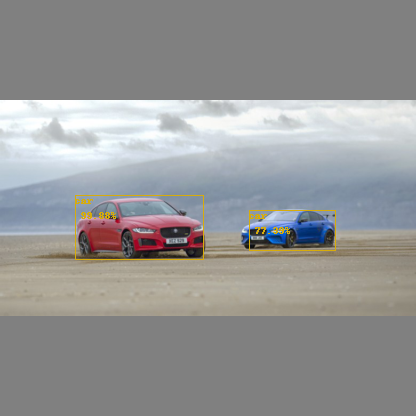

In [240]:
ImgFinal

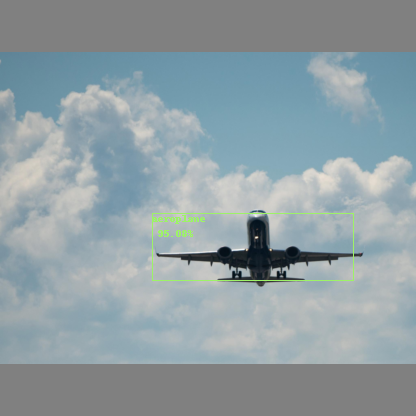

In [273]:
ImgFinal